# **BBM409 ASSIGNMENT 4**

        Eylül TUNCEL - 21727801
        Emre KÖSEN   - 21727498

For this assignment, we implement a Neural Network and CNN to classify the examples on the Animal Classification Dataset mentioned.

## **PART 1**

Below you can see the implementation of our neural network. For Part 1, we implement changing layers of neural network and run experiments on Animal Classification Dataset. We changed parameters (activation func, learning rate, batch size) and put the results to the report.
Changing parameters:
* **Hidden Layer Count :** 
    * 0
    * 1  
    * 2 
* **Activation Functions :** 
    * sigmoid
    * tanh 
    * relu
* **Batch Size :** 
    * 16
    * 32
    * 64 
    * 128
* **Learning rate :** 
    * 0.02
    * 0.01 
    * 0.005
    
As an inputs we gave all pixels of each images. Which means 2500 pixels are given as x0,x1,x2,..,x2500 as the input layer. We have 2500 neurons in the input layer.


<img src=https://ml4a.github.io/images/figures/mnist_1layer.png width="300"> <img src=https://ml4a.github.io/images/figures/weights_analogy_2.png width="400">



<img src=https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg width="600">

We give the changing parameters as a global variables to the functions. If you want to change some parameter, you should change it in the below code part.

In [1]:
import math
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# pixel count in one side
img_size = 50
# total pixels in all input images (as features)
n = img_size * img_size  
c = 10  # number of classes

# changing inputs given as global variables 
hidden_layer_count = 0
learning_rate = 0.005
epoch = 2
batch_size = 128
activation_func = "sigmoid"
# activation_func = "tan"
# activation_func = "relu"

# calculate neuron size for each layer with code logic
neuron_numbers = [n]  # as a start only input neurons are added 

# split the train-validation-test sets with those image counts
# for a better split in numbers we choose (%78 train - %11 validation - %11 test)
total_train_image_count = 20480
total_validation_image_count = 2816
total_test_image_count = 2816

### **Initializing Parameters**
Before starting to train our neural network, we should initialize some parameters like the neuron size of each layer and the initial weight/bias matrices for each layer.
For choosing number of neurons in each layer we use this formula (we think fits best to our data): 

$\sqrt{m+n}$ , where m=inout neurons, n=output neurons

Initial weight matrix is generated with random numbers, and bias matrix generated with all zeros with respect to to the number of neurons in each layer.


<img src=https://ml4a.github.io/images/figures/rolled_weights_mnist_0.png width=400>

In [2]:
def init_parameters():
    # parameters is the dictionary for weights and biases
    parameters = {}
    np.random.seed(101)

    weight = []
    bias = []

    # initializing neuron numbers for each hidden layer by a formula given above
    for i in range(hidden_layer_count):
        x = round(math.sqrt(neuron_numbers[i] + c))
        neuron_numbers.append(x)

    # for each hidden layer there will be weights and biases connected that specific layer
    for i in range(hidden_layer_count):
        wei = np.random.randn(neuron_numbers[i + 1], neuron_numbers[i]) * 0.0001
        bia = np.zeros((neuron_numbers[i + 1], 1))
        weight.append(wei)
        bias.append(bia)

    wei = np.random.randn(c, neuron_numbers[hidden_layer_count]) * 0.0001
    bia = np.zeros((c, 1))
    weight.append(wei)
    bias.append(bia)

    parameters["w"] = weight
    parameters["b"] = bias
    return parameters

The datasets x and y are read from the pixels/images and creating an numpy array with the pixels. 
In x and y, every column represents an image. And batch size of images come together side by side to create x_train numpy array.

In [3]:
def init_train(data, x_train, y_train):
    x_train = np.zeros((n, batch_size))
    y_train = np.zeros((c, batch_size))

    # initializing 
    for i in range(x_train.shape[0]):
        for j in range(x_train.shape[1]):
            x_train[i][j] = data[j][0][i]

    for i in range(y_train.shape[1]):
        class_index = data[i][1]
        y_train[class_index][i] = 1

    return x_train, y_train

### **Activation Functions**

1. **Sigmoid :**

   Sigmoid function is known as the logistic function which helps to normalize the output of any input in the range between 0 to 1.  The sigmoid functions formula is : 
  
    $y=\frac{1}{1+ e^(-x)}$
   
   <img src=https://www.aitude.com/wp-content/uploads/2020/08/sigmoid.png width=300>
2. **Tanh :**

    Tanh Activation function is superior then the Sigmoid Activation function because the range of this activation function is higher than the sigmoid activation function. It ranges between -1 to 1.Here negative values are also considered.
    
   $y=tanh(x)$
   
    <img src=https://www.aitude.com/wp-content/uploads/2020/08/tanh-graph-aitude-768x423.png width=300>
    
3. **Relu :**

    ReLu is the best and most advanced activation function right now compared to the sigmoid and TanH. Here all the negative values are converted into the 0 so there are no negative values are available, but positive values could go to infinity.
    
    $y=max(0,x)$
    
    <img src=https://www.aitude.com/wp-content/uploads/2020/08/relu-activation.png width=300>
    

4. **Softmax :**

    The softmax activation function is for the output layer of the neural network. It’s commonly used in multi-class learning problems where a set of features can be related to one-of-K classes. The values of softmax ranges between 0 to 1.
    
    $y=\frac{e^x}{\sum{e^x}}$
    
    <img src=https://qph.fs.quoracdn.net/main-qimg-5c7cbb4b9fa300ac1de0f1dc3568fa3c width=300>

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    expX = np.exp(x)
    return expX / np.sum(expX, axis=0)

def derivative_sigmoid(x):
    return (1 / (1 + np.exp(-x))) * (1 - (1 / (1 + np.exp(-x))))

def derivative_tanh(x):
    return 1 - np.power(np.tanh(x), 2)

def derivative_relu(x):
    return np.array(x > 0, dtype=np.float32)

### **Forward Propagation**

In forward propagation the input data is fed in the forward direction through the network. Each hidden layer accepts the input data, processes it as per the activation function and passes to the next layer.
In forward propagation, firstly we have x matrix and parameters dictionary(which have weights and biases).
In this part we need to calculate the numbers inside each neuron in each layer. For this purpose we use activation functions.The formula for calculatinons in each layer:

$ Z_i = Weight_i * X_i + Bias_i $ 


$ A_i = activationFunction( Z_i ) $ 



In [5]:
def forward_propagation(x, parameters):
    w = []
    b = []
    for i in range(hidden_layer_count + 1):
        w.append(parameters['w'][i])
        b.append(parameters['b'][i])

    a = []
    z = []
    for i in range(hidden_layer_count + 1):
        if i == 0:  # first
            zi = np.dot(w[i], x) + b[i]
            z.append(zi)
        else:
            zi = np.dot(w[i], a[i - 1]) + b[i]
            z.append(zi)

        if i == hidden_layer_count:  # last element
            ai = softmax(zi)
            a.append(ai)
        else:
            if activation_func == "sigmoid":
                ai = sigmoid(zi)
            elif activation_func == "tan":
                ai = tanh(zi)
            else:
                ai = relu(zi)
            a.append(ai)
    return a

### **Loss Function**

In our assignment, the loss function is "Negative Log Likelihood". In output layer, we have softmax as an activation function and it gives us probabilities of each class. In negative log likelihood loss function we take only the actual class's probability to calculate. And the cost is calculated by taking mean value of all the loss values in the batch. The formula of negative log likelihood is :

$ Loss = - (log(P_i)) $ 

$ Cost =  \frac{1}{m} * \sum{Loss}$ 

<img src=https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log.png width=300>

In [6]:
def cost_function(softmax_layer, y):
    mx = y.shape[1]
    loss = 0
    for j in range(softmax_layer.shape[1]):
        for i in range(softmax_layer.shape[0]):
            if y[i][j] == 1:
                probability = softmax_layer[i][j]
                loss += (-(math.log(probability)))
    cost = (1 / mx) * loss
    return cost

### **Backward Propagation**

Backward propagation refers to the method of calculating the gradient of neural network parameters. The method traverses the network in reverse order, from the output to the input layer, according to the chain rule from calculus. The algorithm stores any intermediate variables (partial derivatives) required while calculating the gradient with respect to some parameters. After the values are calculated, update all parameters with it to actually back propagate. With each batch, the weight of the each neuron changes according to the output and makes it creates the learning process. The calculations are as follows:

* **For output layer (softmax):**

$ Dz_i = DerivativeSoftmax(Z_i) = (A_p - Y) $

* **For other layers:**

$ Dz_i = W_2^T * Dz_p * derivative(Z_i) $

* **The calculationf with derivatives:**

$ Dw_i = \frac{1}{m} * Dz_i * A_1^T$  

$ Db_i = \frac{1}{m} * sum(Dz_i ,1) $ 

$ W_i = W_i - (learning rate) * Dw_i $ 

$ B_i = B_i - (learning rate) * Db_i $ 

In [13]:
def backward_prop(x, y, parameters, forward_cache):
    w = parameters["w"].copy()
    w.reverse()
    a = forward_cache
    a.reverse()
    a.append(x)

    dz = []
    dw = []
    db = []

    m = batch_size

    dz_output = (a[0] - y)
    dw_output = (1 / m) * np.dot(dz_output, a[1].T)
    db_output = (1 / m) * np.sum(dz_output, axis=1, keepdims=True)

    dz.append(dz_output)
    dw.append(dw_output)
    db.append(db_output)

    for i in range(hidden_layer_count):
        if activation_func == "sigmoid":
            dz_i = np.dot(w[i].T, dz[i]) * derivative_sigmoid(a[i + 1])
        elif activation_func == "tan":
            dz_i = np.dot(w[i].T, dz[i]) * derivative_tanh(a[i + 1])
        else:
            dz_i = np.dot(w[i].T, dz[i]) * derivative_relu(a[i + 1])
        dw_i = (1 / m) * np.dot(dz_i, a[i + 2].T)
        db_i = (1 / m) * np.sum(dz_i, axis=1, keepdims=True)
        dz.append(dz_i)
        dw.append(dw_i)
        db.append(db_i)

    dz.reverse()
    dw.reverse()
    db.reverse()

    for i in range(hidden_layer_count + 1):
        parameters['w'][i] = parameters['w'][i] - (learning_rate * dw[i])
        parameters['b'][i] = parameters['b'][i] - (learning_rate * db[i])

    return parameters

In [14]:
def performance(softmax_layer, y):
    true_count = 0
    for j in range(softmax_layer.shape[1]):
        max_prob = -1
        index = -1
        for i in range(softmax_layer.shape[0]):
            if max_prob < softmax_layer[i][j]:
                max_prob = softmax_layer[i][j]
                index = i
        if y[index][j] == 1:
            true_count += 1
    return true_count / softmax_layer.shape[1]

### **Visualizing Parameters**

We visualize some weight matrices when the neural network is single layer. When there is single layer neural network, the weight matrices one side is equal to total input pixels. The shape of weight matrix is [10][2500]. So everyweight values could have 2500 pixels for each 10 classes. We can easily reshape and make an  grayscale image of weights for each output class.

In [9]:
# function for visualizing weights of each output class
def visualize_weights(parameters):
    for i in range(c):
        weight_best = parameters["w"][0][i].reshape((img_size, img_size))
        plt.imshow(weight_best, cmap='gray', vmin=np.amin(weight_best), vmax=np.amax(weight_best))
        plt.savefig(str(i)+".png")
        plt.show()

### **Helper functions for data**

Here are some functions for reading from image data and creating proper data structers from them. After that we need to flatten the image data and normalize the values to 0-1. 

In [10]:
# this function takes all the images urls and their class (which animal)
# creates a new csv file which has urls
def all_image_urls_to_csv():
    folder_names = os.listdir('../Project/raw-img')
    category = []
    files = []
    for k, folder in enumerate(folder_names):
        filenames = os.listdir("../Project/raw-img/" + folder)
        for file in filenames:
            files.append("../Project/raw-img/" + folder + "/" + file)
            category.append(k)

    df = pd.DataFrame({
        'filename': files,
        'category': category
    })
    train_df = pd.DataFrame(columns=['filename', 'category'])
    for i in range(10):
        train_df = train_df.append(df[df.category == i].iloc[:, :])

    df.to_csv('out.csv', index=False)
    return train_df


# 
def create_data(data, url_category_data, start_index, finish_index):
    data = []
    for i in range(start_index, finish_index):
        path = url_category_data[i][0]
        target = url_category_data[i][1]
        try:
            img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            new_img_array = cv2.resize(img_array, (img_size, img_size))
            data.append([new_img_array, target])
        except Exception as e:
            pass
    return data


def flatten_and_normalize_data(data, start_index, end_index):
    for i in range(start_index, end_index):
        arr = np.asarray(data[i][0])
        data[i][0] = arr.reshape((img_size * img_size,)).astype(np.float32)
        data[i][0] = (data[i][0] / 255)
    return data

### **Train and Validation**

In these part of the code, we first train and then validate data for each epoch. In each epoch we creaye mini-batches of changing size(16-32-64-128) and train the parameters with those mini-batches.  After all batches in train data is completed once, one epoch is finished.
After one epoch, validation data is used for measuring the performance after training that epoch. When the validation data has the best performance, we keep that parameters to use in the test set. The reason we do that is to deal with overfitting problem.

In [11]:
def train_amd_validation(x_train, y_train, x_validation, y_validation, url_category_data, learning_rate):
    parameters = init_parameters()
    cost_list = []
    validation_cost_list = []
    start_learning_rate = learning_rate

    best_parameters_from_validation = parameters
    best_performance_from_validation = 0
    train_performance_list = []
    validation_performance_list = []

    for i in range(epoch):  # epoch
        data = []
        performance_val_train = 0
        for j in range(0, total_train_image_count, batch_size):  # batch
            data = create_data(data, url_category_data, j, j + batch_size)
            data = flatten_and_normalize_data(data, 0, batch_size)
            x_train, y_train = init_train(data, x_train, y_train)

            activation_funcs = forward_propagation(x_train, parameters)
            cost = cost_function(activation_funcs[-1], y_train)
            perf_t = performance(activation_funcs[-1], y_train)
            performance_val_train += perf_t
            parameters = backward_prop(x_train, y_train, parameters, activation_funcs)

        cost_list.append(cost)
        performance_val_train = performance_val_train / (total_train_image_count / batch_size)
        train_performance_list.append(performance_val_train)
        print("Cost after", i, "epoch is :", cost)
        print("------------------------------------------------")

        performance_val = 0
        for k in range(total_train_image_count, total_train_image_count + total_validation_image_count, batch_size):
            validation_data = []
            validation_data = create_data(validation_data, url_category_data, k, k + batch_size)
            validation_data = flatten_and_normalize_data(validation_data, 0, batch_size)
            x_validation, y_validation = init_train(validation_data, x_validation, y_validation)
            activation_funcs_v = forward_propagation(x_validation, parameters)
            cost_v = cost_function(activation_funcs_v[-1], y_validation)
            perf = performance(activation_funcs_v[-1], y_validation)
            performance_val += perf
        validation_cost_list.append(cost_v)
        print("Validation Cost :", cost_v)
        performance_val = performance_val / (total_validation_image_count / batch_size)
        validation_performance_list.append(performance_val)
        print("Performance : ", performance_val)
        if performance_val >= best_performance_from_validation:
            best_performance_from_validation = performance_val
            print("BEST PERFORMANCE FOR NOW : ", best_performance_from_validation)
            best_parameters_from_validation = parameters
        print("--------------------------------------------------------------------")

        learning_rate *= 0.95

    plt.title(
        "TRAIN DATA \n" + "Hidden Layer Count:" + str(hidden_layer_count) + "-- Learning Rate:" + str(
            start_learning_rate) + "-- Batch:" + str(batch_size))
    plt.plot(np.arange(0, len(cost_list)), cost_list, label="test")
    plt.plot(np.arange(0, len(validation_cost_list)), validation_cost_list, label="validation")
    plt.ylabel("Cost")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig("cost.png")
    plt.show()

    plt.title("VALIDATION DATA \n" + "Hidden Layer Count:" + str(hidden_layer_count) + "-- Learning Rate:" + str(
        start_learning_rate) + "-- Batch:" + str(batch_size))
    plt.plot(np.arange(0, len(train_performance_list)), train_performance_list, label="train")
    plt.plot(np.arange(0, len(validation_performance_list)), validation_performance_list, label="validation")
    plt.ylabel("Performance")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig("performance.png")
    plt.show()
    return best_parameters_from_validation


In [12]:
def main(learning_rate=learning_rate):
    train_df = all_image_urls_to_csv()
    url_category_data = np.array(train_df.iloc[:, :])
    np.random.seed(101)
    np.random.shuffle(url_category_data)

    x_train = np.zeros((n, batch_size))
    y_train = np.zeros((c, batch_size))

    x_validation = np.zeros((n, batch_size))
    y_validation = np.zeros((c, batch_size))

    x_test = np.zeros((n, batch_size))
    y_test = np.zeros((c, batch_size))

    parameters = train_amd_validation(x_train, y_train, x_validation, y_validation, url_category_data, learning_rate)
    np.save("parameters.npy", parameters)

    test_data = []
    performance_test = 0
    start = total_train_image_count + total_validation_image_count
    for j in range(start, start + total_test_image_count, batch_size):
        test_data = create_data(test_data, url_category_data, j, j + batch_size)
        test_data = flatten_and_normalize_data(test_data, 0, batch_size)
        x_test, y_test = init_train(test_data, x_test, y_test)

        activation_funcs_t = forward_propagation(x_test, parameters)
        perf = performance(activation_funcs_t[-1], y_test)
        performance_test += perf
    performance_test = performance_test / (total_test_image_count / batch_size)
    print("TEST PERFORMANCE", performance_test)

    if hidden_layer_count == 0:
        visualize_weights(parameters)




# **Analysis of Part1**
---------------------------------------------------------

For analysis of part1 we change some parameters and try to observe the outcomes. Here is some example graph. We set the parameters as:

|  | Values | 
| --- | --- |
| Hidden Layer Count | 1 |
| Activation Function |  tanh |
| Batch Size | 32 |
| Learning Rate | 0.02 |
| Accuracy | 32,17 |

Our accuracy in the trials are not so high and we think this is because of low epoch counts we use because we can see the increasing performance and decreasing cost between epochs. So we think if our computers are little bit better and we can run more epochs in suitable timeline, we can see higher accuracy rates. There is an example graph.

P.S.= I accidentally write "test" on the label of the train data sets cost graph. In all graphs, when you see the word "test", we tried to mean "train".

<img src=./hiddenlayer_1/tan/b32_lr0,02/cost.png width=400>

As we can see the cost of test set and train set is decreasing simultaneously as we train the neural network. We use validation to choose best parameters because we expect overfitting with train data. But in this case we didn't see any overfitting, we think it is because of low epoch count. If we keep training, parameters should be overfit in some point. But besides that, we can see that our cost is decreasing properly, therefore the performance is increasing. You can see performance graph below.

<img src=./hiddenlayer_1/tan/b32_lr0,02/performance.png width=400>

### **1. Effects of Changing Hidden Layer**
-------------------------------------------------------

* **Single Layer Neural Network**

In single layer neural networks, there is only one inout layer and one output layer. The activation function for output layer is softmax function. As we can see from the cost and performance graphs, while the cost of train data set is constanly decreasing, the performance increases. And also from the cost graphic, we see the validation set's cost, it first decreases but at some point it started to increase. That point could be the time when overfitting starts. In our implementation when overfitting starts, we store the best parameters for test set. So when overfitting starts, our paraneters stops updating actually. So in this example the best parameters are selected from epoch 5 to 10 where the overfitting just starts.

| | Accuracy|
| -- | -- |
| 0 hidden layer test set | 26,27|

<img src=./hiddenlayer_0/b32_lr0,01/cost.png width=300> <img src=./hiddenlayer_0/b32_lr0,01/performance.png width=300>


* **1 Layer Neural Network**

In 1 layer neural networks, there is one input layer, 1 hidden layer and one output layer. The activation function for hidden layer is tanh function and for output it is softmax function. As we can see from the cost and performance graphs, while the cost of train data set is constanly decreasing, the performance increases

| | Accuracy|
| -- | -- |
| 1 hidden layer test set | 29,11 |

<img src=./hiddenlayer_1/tan/b32_lr0,01/cost.png width=300> <img src=./hiddenlayer_1/tan/b32_lr0,01/performance.png width=300>

* **2 Layer Neural Network**

In 2 layer neural networks, there is one input layer, 2 hidden layers and one output layer. The activation function for hidden layers are tanh function and for output it is softmax function. From the graphs we see that there wasn't much change between the epoch after epoch5. We think that is a problem.

| | Accuracy|
| -- | -- |
| 2 hidden layer test set | 18,25 |

<img src=./hiddenlayer_2/tan/b32_lr0,02/cost.png width=300> <img src=./hiddenlayer_2/tan/b32_lr0,02/performance.png width=300>

**Overall**
As we can see, the performance of 1 hidden layer is the best one. After that single neural network works well too. We think that may be because when there is one hidden layer, it was perfectly learn what it needs to learn.In 1 hidden layer situation our neural network works well and learn more than the others. Most of the best accuracy vvalues are come from 1 hidden layer trials. And when there is more layers, that could fall into the problem of overfitting. And also no hidden layer approach is not a bad approach for our case ı think. It directky classifies by the weights and biasses that learned. 

### **2. Effects of Activation Functions**
----------------------------------------------------------------------------

* **Sigmoid**    $y=\frac{1}{1+ e^(-x)}$
* **Tanh**       $y=tanh(x)$
* **Relu**       $y=max(0,x)$

This time we create our networks with different activation functions in hidden layers. Below you can see the accuracy of each neural network and also cost/performance graphics of each trial. In the trials everything is constant but the activation functions.

Graphics are given with this order: 
1. 1 Layer, Batch Size=64 , Learning Rate=0.01, Activation Function = Sigmoid
2. 1 Layer, Batch Size=64 , Learning Rate=0.01, Activation Function = Tanh
3. 1 Layer, Batch Size=64 , Learning Rate=0.01, Activation Function = Relu

The accuracy values of each trial:

| Hidden Layer Count |Activation Function| Learning Rate | Batch Size | **Test Accuracy** |
| --- | --- | --- | --- | --- |
| 1  | sigmoid |0.01 | 32 | 22 |
| 1  | tanh |0.01 | 32 | 26,56 |
| 1  | relu |0.01 | 32 | 29,50 |



**Cost Graphics of Trials**

1. <img src=./hiddenlayer_1/sigmoid/b32_lr0,01/cost.png width=300> 
2. <img src=./hiddenlayer_1/tan/b64_lr0,01/cost.png  width=300>              
3. <img src=./hiddenlayer_1/relu/b64_lr0,01/cost.png  width=300> 

**Performance Graphics of Trials**

1. <img src=./hiddenlayer_1/sigmoid/b32_lr0,01/performance.png width=300>
2. <img src=./hiddenlayer_1/tan/b64_lr0,01/performance.png  width=300>            
3. <img src=./hiddenlayer_1/relu/b64_lr0,01/performance.png  width=300> 


As we can see from the graphs and accuracy values, Relu is the best and then tanh. The worst activation function amongst them is sigmoid. In sigmoid function and tanh function there is vanishing gradient problem. In those functions the problem arises when a large input space is mapped to a small one, causing the derivatives to disappear. Because of that sigmoid and tanh functions doesn't work well in our dataset.

The advantages of the relu function is, maximum Threshold values are infinity, so there is no issue of Vanishing Gradient problem so the output prediction accuracy and there efficiency is maximum an speed is fast compare to other activation functions.

The performances in our trials, support those issues. We can say relu is the best activation function for us.

### **3. Effect of Changing Batch Size**
---------------------------------------------------------------------------------

For a one layer neural network, we create our networks with different batch sizes. Below you can see the accuracy of each neural network and also cost/performance graphics of each trial.
In the trials everything is constant but the batch size. The batch sizes changes from the values 16-32-64-128. 

Graphics are given with this order: 
1. 1 Layer, Learning Rate=0.01, Batch Size=16
2. 1 Layer, Learning Rate=0.01, Batch Size=32
3. 1 Layer, Learning Rate=0.01, Batch Size=64
4. 1 Layer, Learning Rate=0.01, Batch Size=128

The accuracy values of each trial:

| Hidden Layer Count |Activation Function| Learning Rate | Batch Size | **Test Accuracy** |
| --- | --- | --- | --- | --- |
| 1  | tanh |0.01 | 16 | 31 |
| 1  | tanh |0.01 | 32 | 29 |
| 1  | tanh |0.01 | 64 | 26 |
| 1  | tanh |0.01 | 128 | 21 |



**Cost Graphics of Trials**

1. <img src=./hiddenlayer_1/tan/b16_lr0,01/cost.png width=300> 
2. <img src=./hiddenlayer_1/tan/b32_lr0,01/cost.png  width=300>              
3. <img src=./hiddenlayer_1/tan/b64_lr0,01/cost.png  width=300> 
4. <img src=./hiddenlayer_1/tan/b128_lr0,01/cost.png  width=300>


**Performance Graphics of Trials**


1. <img src=./hiddenlayer_1/tan/b16_lr0,01/performance.png width=300> 
2. <img src=./hiddenlayer_1/tan/b32_lr0,01/performance.png  width=300>              
3. <img src=./hiddenlayer_1/tan/b64_lr0,01/performance.png  width=300> 
4. <img src=./hiddenlayer_1/tan/b128_lr0,01/performance.png  width=300>




As we can see from the accuracy values of each trial, when the batch size is increasing, our performance is increasing a little bit too. We think this situation happens becuase, in lower batch sizes there were more iterations in each epoch. For example, we did out trials with 30 epoch. In batch size 16, there will be 1280 iterations in each epoch. And in batch size 128 there will be 160 iterations in each epoch. That means in lower batch sizes there will be more updates in each epoch. Since each update aims to find local minima of that value with gradient descent, if we do more updates with proper rates we can get to local minima more quickly. Eventhough small batch sizes have more iteration and more time complexity, they has slightly better performance.

From the graphs we can see that smaller batch sizes has more smooth increasing of performance. And also for batch size=16 we can see a little overfitting around the epoch 15. We solve this prolem by choosing he best parameters by validation performance.

### **4. Effect of Changing Learning Rate**
---------------------------------------------------------------

This time we create our networks with different learning rates. Below you can see the accuracy of each neural network and also cost/performance graphics of each trial. In the trials everything is constant but the learning  rates. The learning rates changes from the values 0,02 - 0,01 - 0,005. 

Graphics are given with this order: 
1. 1 Layer, Batch Size=32 , Learning Rate=0.02
2. 1 Layer, Batch Size=32 , Learning Rate=0.01
3. 1 Layer, Batch Size=32 , Learning Rate=0.005

The accuracy values of each trial:

| Hidden Layer Count |Activation Function| Learning Rate | Batch Size | **Test Accuracy** |
| --- | --- | --- | --- | --- |
| 1  | tanh |0.02 | 32 | 32 |
| 1  | tanh |0.01 | 32 | 29 |
| 1  | tanh |0.005 | 32 | 27 |



**Cost Graphics of Trials**

1. <img src=./hiddenlayer_1/tan/b32_lr0,02/cost.png width=300> 
2. <img src=./hiddenlayer_1/tan/b32_lr0,01/cost.png  width=300>              
3. <img src=./hiddenlayer_1/tan/b32_lr0,05/cost.png  width=300> 

**Performance Graphics of Trials**

1. <img src=./hiddenlayer_1/tan/b32_lr0,02/performance.png width=300> 
2. <img src=./hiddenlayer_1/tan/b32_lr0,01/performance.png  width=300>              
3. <img src=./hiddenlayer_1/tan/b32_lr0,05/performance.png  width=300> 

As we can see from the accuracy values, bigger learning rate has better performance. Actually we know that if the learning rate is too high, the gradient descent can overshoot the minimum and it may fail to converge. But also if the learning rate is too small, gradient descent is small and it takes so much time, iterations to reach miinimum. Both ways is bad for us. 
As we can see from the trials, the best performance is when the learning rate is 0,02 which is highest in our trials. It means it is not too high for our data. But from the cost graphics we can say that learning rate 0,005 is too small because in 30 epochs the cost is not decreases as much as we wanted to.
From our outputs and graphs we say that learning rate 0,02 is the better choice amongst others. It has better capability to reduce cost in more faster way and it does noy misses any minimum as we can see. And for preventing this we also reduce the learning rate by multiplying it by a decay rate.

## **Visualizing Parameters**

Weight matrix of **butterfly** output class:

<img src=./visualization/4.png width=300>

Weight matrix of **elephant** output class:

<img src=./visualization/6.png width=300> 

Weight matrix of **chicken** output class:

<img src=./visualization/5.png width=300> 

Weight matrix of **spider** output class:

<img src=./visualization/2.png width=300> 

Those images of weight matrices are taken from single layer neural networks. The reason behind this is tho get an same image size with the weight matrix. And also images are more precise when de the epoch size is decreasing. If the epoch size is too high most of the images looks like this:

A butterfly when epoch is much higher:

<img src=./hiddenlayer_0/b32_lr0,01/4.png width=300> 


### **Accuracy Tables of Hidden Layers:**

Since we don't have powerfull computers, our trials took so much time. Because of that we couldn't finish our trials but we put the performance values of trials that we complete.

For 0 hidden layer, only activation function we use is softmax, in the output layer. So we don't have to try each activation function over and over again. Here is the table of 0 hidden layer performance values:
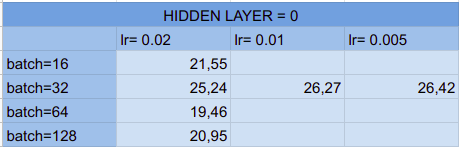

For hidden layer 1, we did different trials for each activaion function (sigmoid, tanh, relu). 
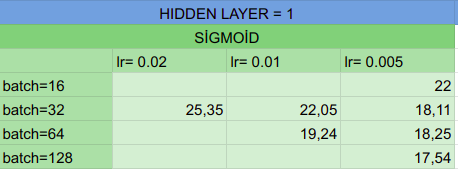

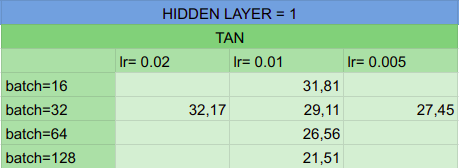

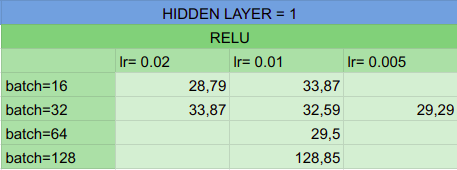

** You can find all the graphs in the files I attach with the submit. And also I added best parameters fore every trial, in those files too. The file named "parameters.npy" has the numpy array with the bst weight and bias values. 

# **PART 2**
---------------------------------

### **Convulational Neural Network**

Convolutional Neural Network (CNN) is an neural network which extracts or identifies a feature in a particular image. CNN has the following five basic components:

* **Convolution** : to detect features in an image
* **ReLU** : to make the image smooth and make boundaries distinct
* **Pooling** : to help fix distored images
* **Flattening** : to turn the image into a suitable representation
* **Full connection** : to process the data in a neural network

### **VGG-19**

In this part of the assignment, we used pretrained VGG-19 convolutional neural network (CNN) and finetune this network to classify the sample images.
Here is the the figure of VGG-19 network architecture:
<img src=https://ichi.pro/assets/images/max/724/0*E6BE6GDv-53smX0B.jpg wifth=400>


So in simple language VGG is a deep CNN used to classify images.It is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). The layers in VGG19 model are as follows:

* Conv3x3 (64)
* Conv3x3 (64)
* MaxPool
* Conv3x3 (128)
* Conv3x3 (128)
* MaxPool
* Conv3x3 (256)
* Conv3x3 (256)
* Conv3x3 (256)
* Conv3x3 (256)
* MaxPool
* Conv3x3 (512)
* Conv3x3 (512)
* Conv3x3 (512)
* Conv3x3 (512)
* MaxPool
* Conv3x3 (512)
* Conv3x3 (512)
* Conv3x3 (512)
* Conv3x3 (512)
* MaxPool
* Fully Connected (4096)
* Fully Connected (4096)
* Fully Connected (1000)
* SoftMax

### **Initializing Parameters**
Before starting, we should initialize some parameters like batch size, epoch number, learning rate etc. and do necessary imports. And we have translate dictionary which is for translation of image class to animal name.

In [4]:
import os
import torch
import numpy as np
import pandas as pd
from torch.functional import split
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from collections import OrderedDict
from torchvision import datasets, models, transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
             "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
             "ragno": "spider", "scoiattolo": "squirrel" }

classes = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora","ragno", "scoiattolo" ]

batch_size = 60
disimage = 20
epoch = 10
learning_rate = 0.005
is_all_grad = True

ModuleNotFoundError: No module named 'torch'

### Initializing Data

Here we get the images and transform them with different filters like rotation and resize. With max_length variable we choose how many images we want to get from each image class.

In [5]:
def initialize_data():
    for dirname, _, filenames in os.walk('./raw-img'):
        for filename in filenames:
            path, folder = os.path.split(dirname)

    data_transform = transforms.Compose([transforms.RandomRotation(45),
                                          transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(1080),
                                          transforms.Resize(512),
                                          transforms.Resize(224),
                                          transforms.RandomRotation(45),
                                          transforms.ToTensor()])

    dataset = datasets.ImageFolder(path, transform=data_transform)

    max_length = 1400
    idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[dataset.classes[0]]]
    subset = Subset(dataset, idx)
    data = Subset(subset, idx[:max_length])

    for j in range(1, 10):
        idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[dataset.classes[j]]]
        subset = Subset(dataset, idx[:max_length])
        data = ConcatDataset((data, subset))
        print(len(data))

    return data

# dataset = initialize_data()

### Splitting the Data

In split_data function we randomly shuffle the dataset and split it to train, validation and test sets. Then we load them to DataLoader of PyTorch for model to be able to work with them.

In [6]:
def split_data(dataset_length, validation_size=0.1, test_size=0.1):
    indices = [i for i in range(dataset_length)]
    np.random.shuffle(indices)
    validation_dataset = int(np.floor((validation_size) * dataset_length))
    test_dataset = int(np.floor((validation_size+test_size) * dataset_length))
    validation_idx, test_idx, train_idx = indices[:validation_dataset], indices[validation_dataset:test_dataset], indices[test_dataset:]
    return validation_idx, test_idx, train_idx

# validation_idx, test_idx, train_idx = split_data(len(dataset), 0.1, 0.1)

# train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size)
# valid_loader = DataLoader(Subset(dataset,validation_idx), batch_size=batch_size)
# test_loader = DataLoader(Subset(dataset,test_idx), batch_size=batch_size)

### Creating the Model

To create our model we use PyTorch. With PyTorch you can use models.vgg19 to use VGG-19. We specify the classifier filters and attach it to our model. With is_all_grad boolean we finetune all parameters or just finetune the last 2 of them.

In [7]:
def create_model(is_all_grad=True):
    model = models.vgg19(pretrained=True)
    model.cu
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 6000)), ('relu', nn.ReLU()), ('dropout', nn.Dropout(.5)), ('fc2', nn.Linear(6000, 10)), ('output', nn.Softmax(dim=1) )]))        
    model.classifier = classifier

    if(not is_all_grad):
        for name, param in model.named_parameters():
            print(name, param.size())
            param.requires_grad = False

        for name, param in model.named_parameters():
            if(name == "classifier.fc1.weight" or name == "classifier.fc1.bias" or name == "classifier.fc2.weight" or name == "classifier.fc2.bias"):
                print(name)
                print(param.requires_grad)
                param.requires_grad = True
                print(param.requires_grad)


    return model

# model = create_model(False)

### Training the Model

Here we specify our optimizer, loss function and function which trains the model. In function we get images with batches, train the model with images and do backward propagation. Last we calculate correct classses, total classes and train loss.

In [8]:
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# loss_function = nn.NLLLoss()

def seq(model, df, name):
    train_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    for batch_i, (data, target) in enumerate(df):
        print("Batch " + str(batch_i) + ":")
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = loss_function(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        if name == 'train': 
            loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        _, pred = torch.max(output, 1) 
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy())
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
    return class_correct, class_total, train_loss

### Printing the Data

We print the loss, accuracy for each epoch. Also we collect the loss and accuracy values for plotting graph later. 

In [9]:
def printdata(class_correct, class_total, train_loss, epoch, name, df, loss_values, accuracy_values):
    loss = train_loss / len(df)
    accuracy = 100.0 * np.sum(class_correct) / np.sum(class_total)
    
    print("Epoch ", epoch, "loss: ", loss, "\t", name, " Accuracy(Overall): ", accuracy, "(", np.sum(class_correct), "/", np.sum(class_total), ")")
    
    for i in range(10):
        if class_total[i] > 0:
            print(f'{name} Accuracy of %5s: %2d%% (%2d/%2d)' % (
            translate[classes[i]], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

    loss_values.append(loss)
    accuracy_values.append(accuracy)

### Plotting the Loss and Accuracy Graph

Here we plot the epoch-cost and epoch-accuracy graph.

In [10]:
def plot_loss_and_accuracy(train_loss_values, train_accuracy_values, validation_loss_values, validation_accuracy_valeus):
    plt.subplot(1,2,1)
    plt.title("TRAIN DATA \n" + "-- Learning Rate:" + str(learning_rate) + "-- Batch:" + str(batch_size))
    plt.plot(np.arange(0, len(train_loss_values)), train_loss_values, label="train")
    plt.plot(np.arange(0, len(validation_loss_values)), validation_loss_values, label="validation")
    plt.ylabel("Cost")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig("cost.png")

    plt.subplot(1,2,2)
    plt.title("TRAIN DATA \n" + "-- Learning Rate:" + str(learning_rate) + "-- Batch:" + str(batch_size))
    plt.plot(np.arange(0, len(train_accuracy_values)), train_accuracy_values, label="train")
    plt.plot(np.arange(0, len(validation_accuracy_valeus)), validation_accuracy_valeus, label="validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig("accuracy.png")
    plt.show()

### Training the Model

In above seq function we train the model with many batches in one epoch. Here we use that seq function and use more epochs. Also we validate our model with validation dataset to see whether our model is overfit or not. Last we save the model for later use.

In [11]:
def trainModel(model, train_loader,valid_loader, num_epochs=1):
    train_loss_values = []
    train_accuracy_values = []
    validation_loss_values = []
    validation_accuracy_values = []

    # number of epochs to train the model
    for epoch in range(1, num_epochs+1):
        train_loss = 0.0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        # train the model
        # Repeat for each batch in the training set
        model.train()
        class_correct, class_total, train_loss= seq(model,  train_loader, 'train')
        printdata(class_correct, class_total, train_loss, epoch, 'train', train_loader, train_loss_values, train_accuracy_values)
        # Repeat for each validation batch 
        model.eval()
        class_correct, class_total, train_loss= seq(model, valid_loader, 'validation')
        printdata(class_correct, class_total, train_loss, epoch, 'validation', valid_loader, validation_loss_values, validation_accuracy_values)

    plot_loss_and_accuracy(train_loss_values, train_accuracy_values, validation_loss_values, validation_accuracy_values)
    torch.save(model.state_dict(), 'model.pt')     
    

In [12]:
# trainModel(model, train_loader, valid_loader, 2)

### Testing the Model

Here we use our test dataset to calculate our models accuracy.

In [13]:
def testModel(model, test_loader):
    test_loss = 0.0
    class_correct = [0. for i in range(10)]
    class_total = [0. for i in range(10)]
    model.eval()
    class_correct, class_total, train_loss= seq(model, test_loader, 'test')
    printdata(class_correct, class_total, train_loss, 1, 'test', test_loader, [], [])

## Analysis

Since we have limited resources to train our model we only be able to train our model with 10 epoch and 1000 image from each class which means 10000 images. Because of that our accuracy values may not be look high but it's promising.

### 1 - Finetune the weights of all layers in the VGG-19 network

| Description | Dog | Horse | Elephant | Butterfly | Chicken | Cat | Cow | Sheep | Spider | Squirrel |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Validation | %89 | %48 | %62 | %86 | %69 | %26 | %38 | %58 | %73 | %53 |
|  | (88/98) | (45/93) | (73/117) | (100/116) | (72/103) | (24/89) | (34/88) | (68/117) | (66/90) | (48/89) | 
| Test | %91 | %55 | %65 | %87 | %79 | %23 | %47 | %60 | %78 | %48 |
|  |  (83/91) | (62/112) | (57/87) | (97/111) | (71/89) | (21/91) | (59/124) | (59/98) | (82/104) | (45/93) |

We can see that our accuracy values are nor high or low. This can be happen because of small image number or small epoch count.

<img src=./visualization/part1.png width=600>

If we look to graphs we can see that our cost decreases and accuracy increases. This graph shows our model is works well and promising and if we had better computing power we could achieve bigger accuracy in our model. From view point of graph maybe we can say that after Epoch 8 our model overfits because cost of train decreases and cost of validation increases and accuracy of train increases and accuracy of validation decreases. Also this might be little problem and we might achieve better accuracy with more epoch count.

<img src=./visualization/vgg19_output.png width=1000>

If we select randomly 20 images from our test data we can see that 15 out of 20 are correct. For some images we can see that even with correct labels images are hard to predict for example third and eleventh images.


### 2 - Finetune the weights of only two last fully connected (FC1 and FC2) layers in the VGG-19 network

| Description | Dog | Horse | Elephant | Butterfly | Chicken | Cat | Cow | Sheep | Spider | Squirrel |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Validation | %45 | %46 | %68 | %76 | %80 | %95 | %42 | %73 | %66 | %63 |
|  | (50/109) | (47/102) | (82/120) | (74/97) | (75/93) | (95/99) | (37/87) | (63/86) | (71/107) | (63/100) | 
| Test | %47 | %46 | %62 | %80 | %77 | %96 | %49 | %73 | %64 | %63 |
|  |  (46/97) | (47/102) | (59/95) | (89/110) | (88/113) | (82/85) | (52/106) | (76/104) | (59/92) | (61/96) |

When we finetune just last two fully connected layers still our accuracy values are nor high or low. Since the values happen because of small image number or small epoch count we might not be able to see difference between finetuning the all layers or last two fully connected layers.

<img src=./visualization/part2.png width=600>

In graphs we can see that our cost decreases and accuracy increases. This graph also shows our model is works well and promising and if we had better computing power we could achieve bigger accuracy in our model. With this model our validation dataset performs better between Epoch 4 and Epoch 10. This can be happen because of finetuning but also happen because of the data since we shuffle the data before training the model second time. Since the complexity is higher when finetuning the all weights it might perform better with more data.

<img src=./visualization/vgg19_output2.png width=1000>

Again we select 20 randomly images from our test data and we see that 15 out of 20 images are correct. 

